# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Modelling
5. Hyperparameter Tuning
6. Evaluation


# SET-UP

## Import Library

In [126]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import warnings
import time
warnings.filterwarnings("ignore")

#EDA
from tabulate import tabulate
# ouliers
from scipy import stats
# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [127]:
data_final = pd.read_csv("BTC-USD.csv")

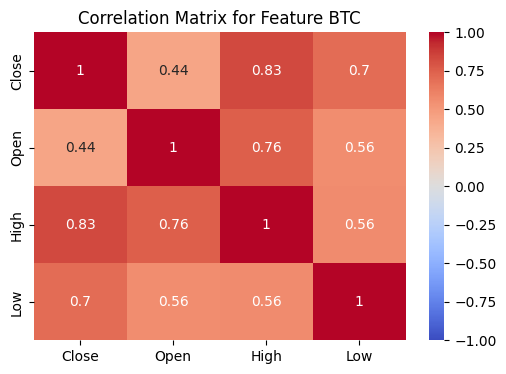

In [128]:
# Function to calculate correlation
corr_matrix = data_final[['Close', 'Open', 'High', 'Low']].corr()

# Plot correlation matrices
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Feature BTC')
plt.show()

# EDA

In [129]:
# Read Data
data_final

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-01,42280.234375,44175.437500,42214.976563,44167.332031,44167.332031,18426978443
1,2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750,44957.968750,39335274536
2,2024-01-03,44961.601563,45503.242188,40813.535156,42848.175781,42848.175781,46342323118
3,2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875,44179.921875,30448091210
4,2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406,44162.691406,32336029347
5,2024-01-06,44178.953125,44227.632813,43475.156250,43989.195313,43989.195313,16092503468
6,2024-01-07,43998.464844,44495.570313,43662.230469,43943.097656,43943.097656,19330573863
7,2024-01-08,43948.707031,47218.000000,43244.082031,46970.503906,46970.503906,42746192015
8,2024-01-09,46987.640625,47893.699219,45244.714844,46139.730469,46139.730469,39821290992
9,2024-01-10,46121.539063,47647.222656,44483.152344,46627.777344,46627.777344,50114613298


In [130]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,10.0,4.437131e+04,1.388307e+03,4.228023e+04,4.396115e+04,4.418305e+04,4.476945e+04,4.698764e+04
High,10.0,4.561838e+04,1.473529e+03,4.417544e+04,4.438886e+04,4.513663e+04,4.688843e+04,4.789370e+04
Low,10.0,4.327747e+04,1.252839e+03,4.081354e+04,4.270256e+04,4.335962e+04,4.404827e+04,4.524471e+04
Close,10.0,4.479864e+04,1.344284e+03,4.284818e+04,4.403257e+04,4.417363e+04,4.584429e+04,4.697050e+04
Adj Close,10.0,4.479864e+04,1.344284e+03,4.284818e+04,4.403257e+04,4.417363e+04,4.584429e+04,4.697050e+04
Volume,10.0,3.349939e+10,1.221170e+10,1.609250e+10,2.210995e+10,3.583565e+10,4.201497e+10,5.011461e+10


In [131]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10 non-null     object 
 1   Open       10 non-null     float64
 2   High       10 non-null     float64
 3   Low        10 non-null     float64
 4   Close      10 non-null     float64
 5   Adj Close  10 non-null     float64
 6   Volume     10 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 692.0+ bytes


In [132]:
#drop feature that not used in this analysis ( 'Open', 'High', 'Low', 'Adj Close', 'Volume')
data_final = data_final.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data_final

,Date,Close
0,2024-01-01,44167.332031
1,2024-01-02,44957.968750
2,2024-01-03,42848.175781
3,2024-01-04,44179.921875
4,2024-01-05,44162.691406
5,2024-01-06,43989.195313
6,2024-01-07,43943.097656
7,2024-01-08,46970.503906
8,2024-01-09,46139.730469
9,2024-01-10,46627.777344


In [133]:
# Data Type Conversion
# Convert 'Date' to datetime if not already done
data_final['Date'] = pd.to_datetime(data_final['Date'])

#Feature Engineering
#Extract date parts
data_final['year'] = data_final['Date'].dt.year
data_final['month'] = data_final['Date'].dt.month
data_final['day'] = data_final['Date'].dt.day

data_final

,Date,Close,year,month,day
0,2024-01-01,44167.332031,2024,1,1
1,2024-01-02,44957.968750,2024,1,2
2,2024-01-03,42848.175781,2024,1,3
3,2024-01-04,44179.921875,2024,1,4
4,2024-01-05,44162.691406,2024,1,5
5,2024-01-06,43989.195313,2024,1,6
6,2024-01-07,43943.097656,2024,1,7
7,2024-01-08,46970.503906,2024,1,8
8,2024-01-09,46139.730469,2024,1,9
9,2024-01-10,46627.777344,2024,1,10


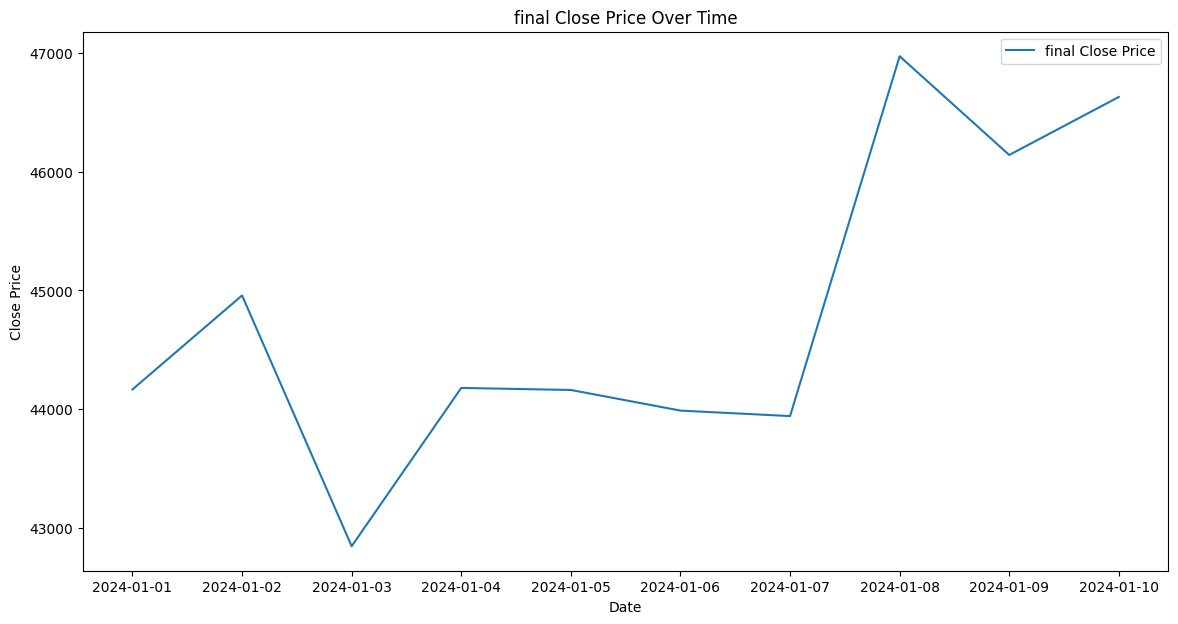

In [134]:
# visualisasi data close price / day
data_final.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(data_final['Close'], label='final Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('final Close Price Over Time')
plt.legend()
plt.show()


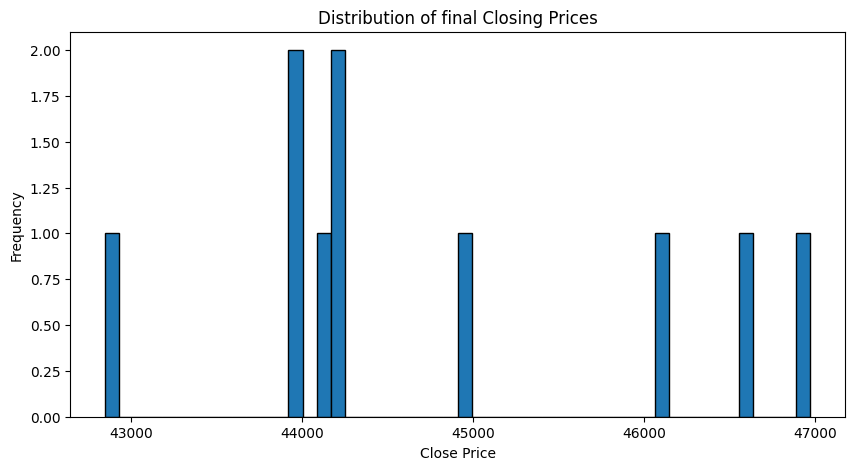

In [135]:
plt.figure(figsize=(10, 5))
plt.hist(data_final['Close'], bins=50, edgecolor='k')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of final Closing Prices')
plt.show()


<Figure size 1200x600 with 0 Axes>

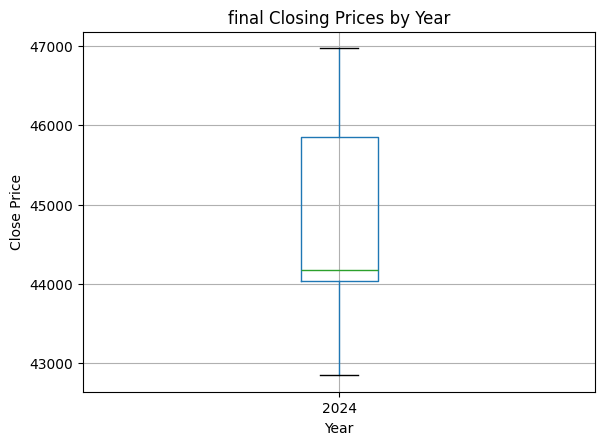

In [136]:
data_final['Year'] = data_final.index.year

plt.figure(figsize=(12, 6))
data_final.boxplot(column='Close', by='Year')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('final Closing Prices by Year')
plt.suptitle('')  # Suppress the automatic title
plt.show()

# DATA PREPROCESSING

Steps for Data Preprocessing:
1. Handling Missing Values 
2. Data Type Conversion ✅
3. Feature Engineering ✅
4. Normalization/Scaling (Tidak dilakukan karena model yang kita gunakan tidak membutuhkan scaling)
5. Handling Outliers

In [137]:
# Check for missing values
data_final.isnull().sum()


Close    0
year     0
month    0
day      0
Year     0
dtype: int64

In [138]:
z_scores = np.abs(stats.zscore(data_final))

# Mengidentifikasi outlier (Z-Score > 3)
outlier_mask = (z_scores > 3).any(axis=1)

# Menghitung jumlah outlier
num_outliers = outlier_mask.sum()

# Memeriksa apakah ada outlier atau tidak
if num_outliers > 0:
    print(f"Terdapat {num_outliers} baris yang mengandung outlier.")
    print("Berikut adalah indeks baris yang mengandung outlier:")
    print(df.loc[outlier_mask].index)
else:
    print("Tidak ada outlier dalam data.")

Tidak ada outlier dalam data.


In [139]:
# Menghitung Z-Score untuk kolom 'Close'
z_scores = np.abs(stats.zscore(data_final[['Close']]))

# Mengidentifikasi outlier (Z-Score > 3)
outlier_mask = (z_scores > 3).any(axis=1)

# Membuat kolom baru 'Close_interpolated' yang berisi data tanpa outlier
data_final['Close_interpolated'] = data_final['Close'].copy()

# Mengisi nilai outlier dengan interpolasi linear pada kolom 'Close_interpolated'
data_final.loc[outlier_mask, 'Close_interpolated'] = np.nan
data_final['Close_interpolated'].interpolate(method='linear', limit_direction='both', inplace=True)

# Menampilkan DataFrame yang telah diperbarui
print(data_final['Close_interpolated'])

Date
2024-01-01    44167.332031
2024-01-02    44957.968750
2024-01-03    42848.175781
2024-01-04    44179.921875
2024-01-05    44162.691406
2024-01-06    43989.195313
2024-01-07    43943.097656
2024-01-08    46970.503906
2024-01-09    46139.730469
2024-01-10    46627.777344
Name: Close_interpolated, dtype: float64


In [140]:
# Melihat jumlah nilai yang hilang di setiap kolom
print(data_final.isnull().sum())

# Atau, melihat lokasi nilai yang hilang
print(data_final[data_final.isnull().any(axis=1)])

Close                 0
year                  0
month                 0
day                   0
Year                  0
Close_interpolated    0
dtype: int64
Empty DataFrame
Columns: [Close, year, month, day, Year, Close_interpolated]
Index: []


In [141]:
# Check Descriptive Statistic
print("\n\n")
print("Check Descriptive Statistic")
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
data_final.describe().style.format("{:,.0f}")




Check Descriptive Statistic
Data memiliki 10 baris dan 6 kolom


,Close,year,month,day,Year,Close_interpolated
count,10,10,10,10,10,10
mean,"44,799","2,024",1,6,"2,024","44,799"
std,"1,344",0,0,3,0,"1,344"
min,"42,848","2,024",1,1,"2,024","42,848"
25%,"44,033","2,024",1,3,"2,024","44,033"
50%,"44,174","2,024",1,6,"2,024","44,174"
75%,"45,844","2,024",1,8,"2,024","45,844"
max,"46,971","2,024",1,10,"2,024","46,971"


In [142]:
# Split train - test data
train_size = int(len(data_final) * 0.8)
train_final, test_final = data_final.iloc[:train_size], data_final.iloc[train_size:]

print(f"Jumlah data train: {len(train_final)} baris")
print(f"Jumlah data test: {len(test_final)} baris")

# Show the data
print("Train Data:")
print(train_final.head())
print("\nTest Data:")
print(test_final.head())


Jumlah data train: 8 baris
Jumlah data test: 2 baris
Train Data:
                   Close  year  month  day  Year  Close_interpolated
Date                                                                
2024-01-01  44167.332031  2024      1    1  2024        44167.332031
2024-01-02  44957.968750  2024      1    2  2024        44957.968750
2024-01-03  42848.175781  2024      1    3  2024        42848.175781
2024-01-04  44179.921875  2024      1    4  2024        44179.921875
2024-01-05  44162.691406  2024      1    5  2024        44162.691406

Test Data:
                   Close  year  month  day  Year  Close_interpolated
Date                                                                
2024-01-09  46139.730469  2024      1    9  2024        46139.730469
2024-01-10  46627.777344  2024      1   10  2024        46627.777344


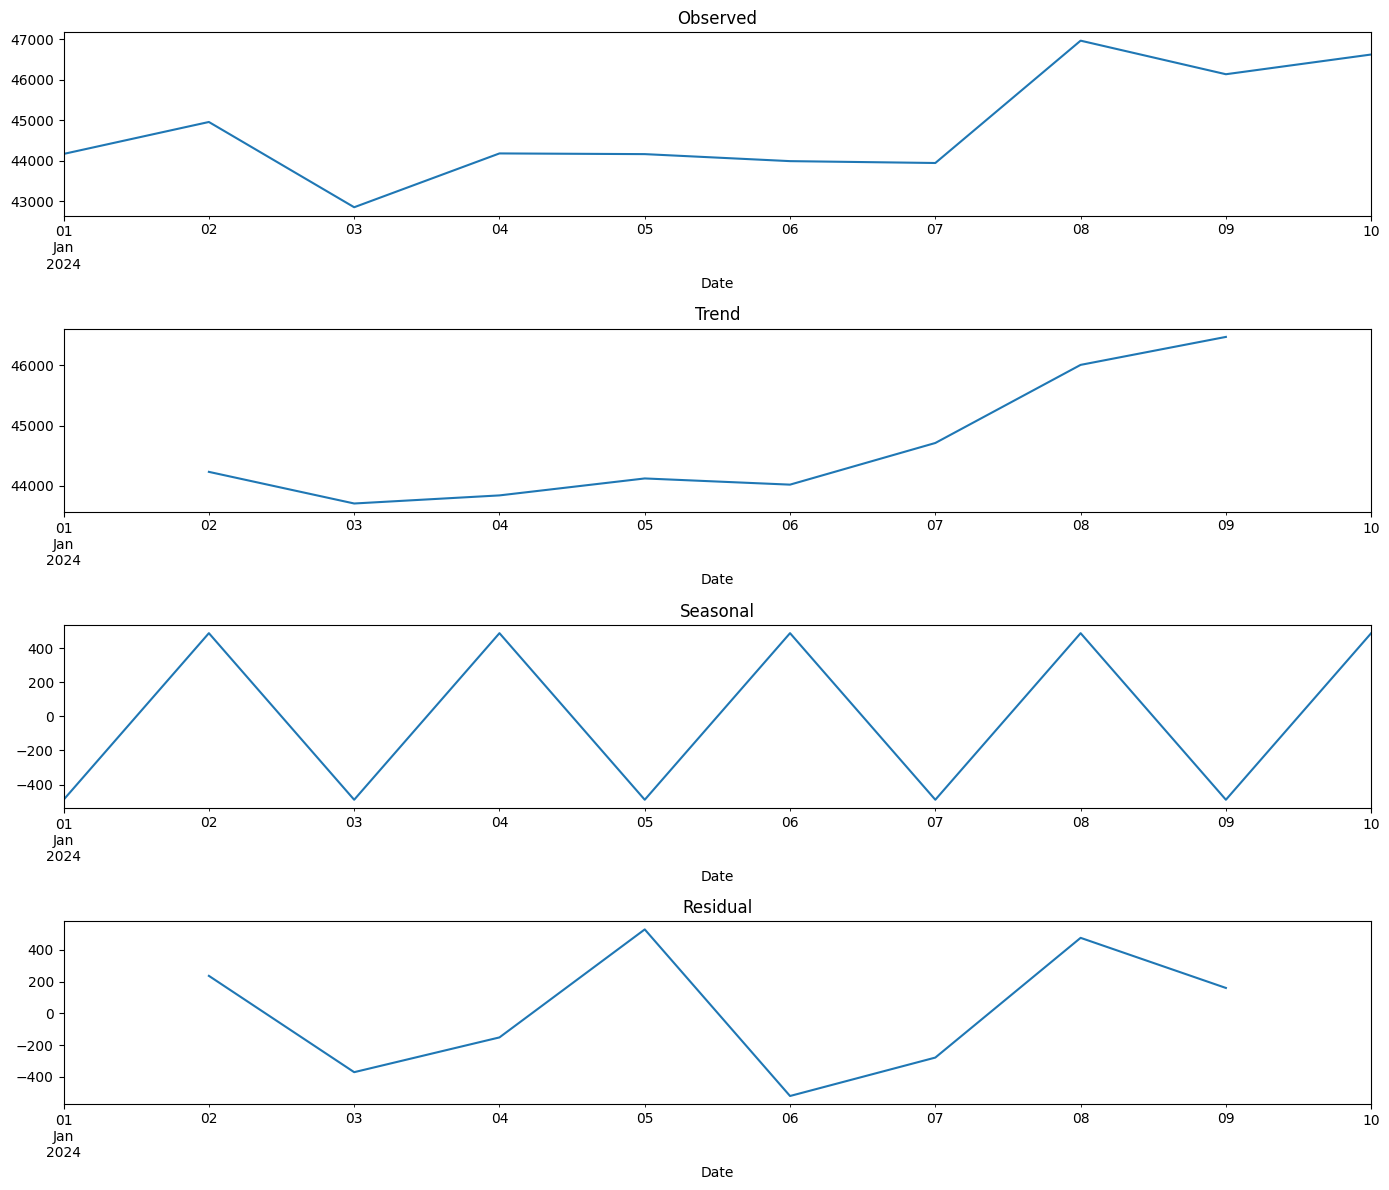

In [143]:
# Assuming data_final['Close'] is your time series data
result = seasonal_decompose(data_final['Close_interpolated'], model='additive', period=2)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

# PERHITUNGAN MANUAL

## Triple Exponential Smoothing

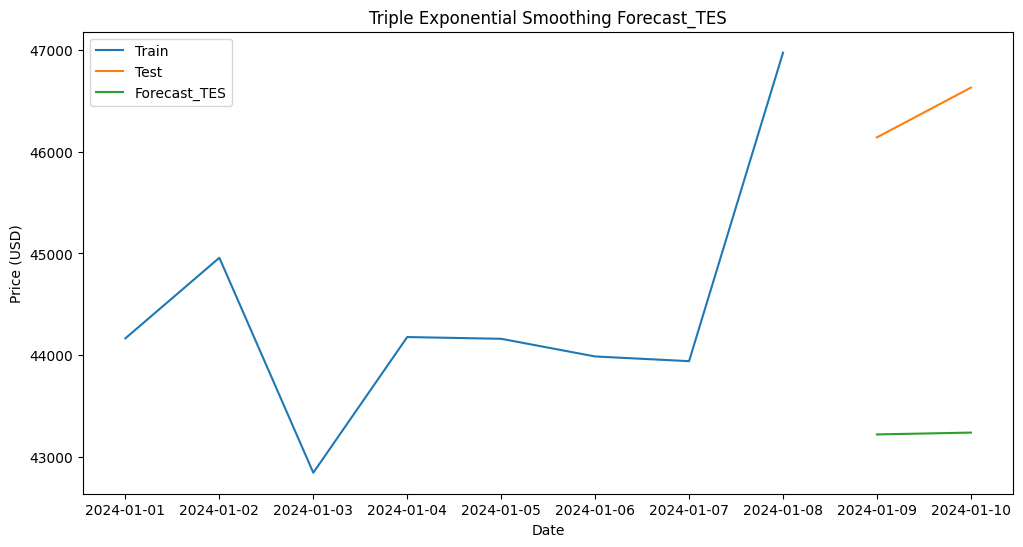

RMSE: 3159.45
MAPE: 6.79%


In [144]:
hw_train_df = train_final[['Close_interpolated']]
hw_test_df = test_final[['Close_interpolated']]

# Model Triple Exponential Smoothing (TES)
def fit_tes(train, test, seasonal_periods, level=None, slope=None, seasonal=None):
    # Build the model
    model = ExponentialSmoothing(train,  trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    # model_fit = model.fit(optimized=True) // otomatis
    
    # manual
    model_fit = model.fit(smoothing_level=level, 
                          smoothing_slope=slope, 
                          smoothing_seasonal=seasonal, 
                          optimized=True if (level is None and slope is None and seasonal is None) else False) 
    
    # Forecast
    forecast_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast_TES

# Train the model
seasonal_periods = 2 # Set the seasonal period to 30 days, karena saya merasa ada seasonality pada data harga bitcoin setiap bulannya
level = 0.2   # Set level smoothing parameter
slope = 0.1   # Set slope smoothing parameter
seasonal = 0.3  # Set seasonal smoothing parameter
model_fit, forecast_TES = fit_tes(hw_train_df['Close_interpolated'], hw_test_df['Close_interpolated'], seasonal_periods, level, slope, seasonal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hw_train_df['Close_interpolated'], label='Train')
plt.plot(hw_test_df['Close_interpolated'], label='Test')
plt.plot(forecast_TES, label='Forecast_TES')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.title('Triple Exponential Smoothing Forecast_TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_TES = np.sqrt(mean_squared_error(hw_test_df['Close_interpolated'], forecast_TES))
mape_TES = np.mean(np.abs((hw_test_df['Close_interpolated'] - forecast_TES) / hw_test_df['Close_interpolated'])) * 100

print(f'RMSE: {rmse_TES:.2f}')
print(f'MAPE: {mape_TES:.2f}%')




## ARIMA

### Plot Data

In [145]:
# Import packages
import plotly.express as px
arima_train_df = train_final[['Close_interpolated']]
arima_test_df = test_final[['Close_interpolated']]

def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='day', y=y, labels={'Day': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Bitcoin Price',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the airline passenger data
plot_passenger_volumes(df=train_final, y='Close_interpolated')

### ACF and PACF plot for time series

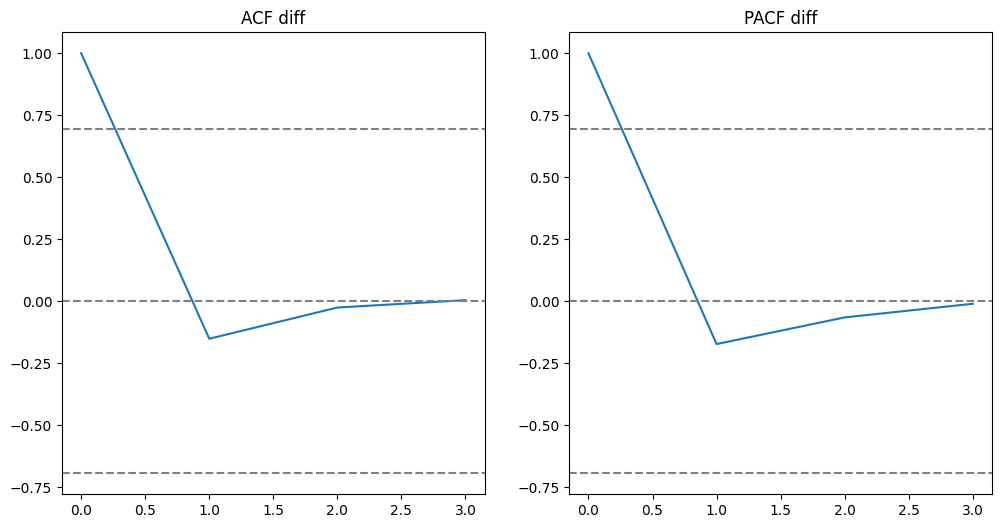

In [146]:
# Identifikasi Orde ARIMA (p, d, q)
# ACF and PACF plots
acf_plot = acf(arima_train_df, nlags=3)
pacf_plot = pacf(arima_train_df, nlags=3)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(arima_train_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(arima_train_df)), linestyle='--', color='gray')
plt.title('ACF diff')
plt.subplot(122)
plt.plot(pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(arima_train_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(arima_train_df)), linestyle='--', color='gray')
plt.title('PACF diff')
plt.show()

### Check Stationary Data

In [147]:
#Check Stationary Data pada arima_train_df
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

# Check stationarity of Close prices
check_stationarity(arima_train_df['Close_interpolated'])

ADF Statistic: -1.824973
p-value: 0.368135
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Series is non-stationary


In [148]:
# Differencing to make data stationary
train_final_diff = arima_train_df['Close_interpolated'].diff()
train_final_diff.dropna(inplace=True)

check_stationarity(train_final_diff)

ADF Statistic: -2.545331
p-value: 0.104831
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Series is non-stationary


In [149]:
# Differencing to make data stationary
train_final_diff1 = train_final_diff.diff()
train_final_diff1.dropna(inplace=True)

check_stationarity(train_final_diff1)

ADF Statistic: -4.114929
p-value: 0.000915
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
Series is stationary


In [150]:
train_final_diff1

Date
2024-01-03   -2900.429688
2024-01-04    3441.539063
2024-01-05   -1348.976563
2024-01-06    -156.265624
2024-01-07     127.398436
2024-01-08    3073.503907
Name: Close_interpolated, dtype: float64

### Identifikasi Orde ARIMA dengan ACF dan PACF 

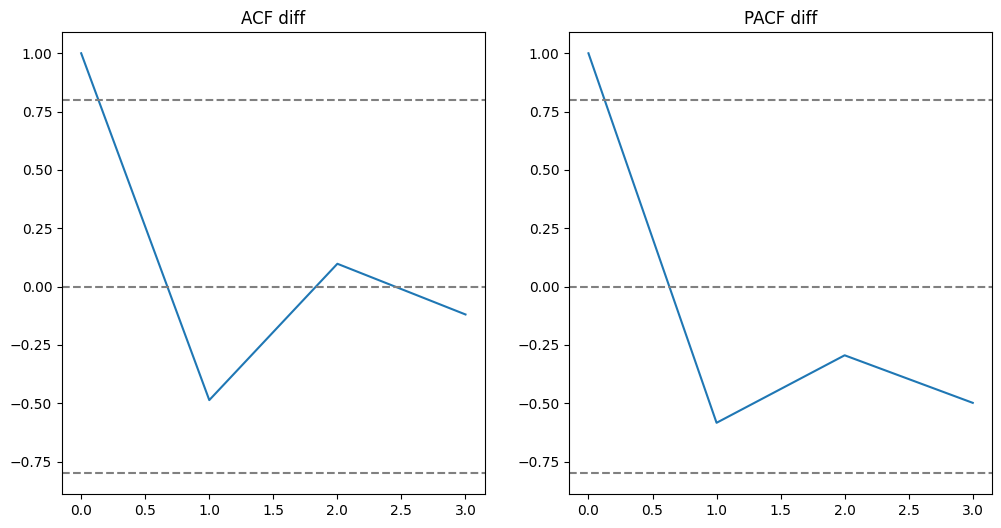

In [151]:
# Identifikasi Orde ARIMA (p, d, q) dengan ACF and PACF plots data diff
# ACF and PACF plots
acf_plot = acf(train_final_diff1, nlags=3)
pacf_plot = pacf(train_final_diff1, nlags=3)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff1)), linestyle='--', color='gray')
plt.title('ACF diff')
plt.subplot(122)
plt.plot(pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff1)), linestyle='--', color='gray')
plt.title('PACF diff')
plt.show()

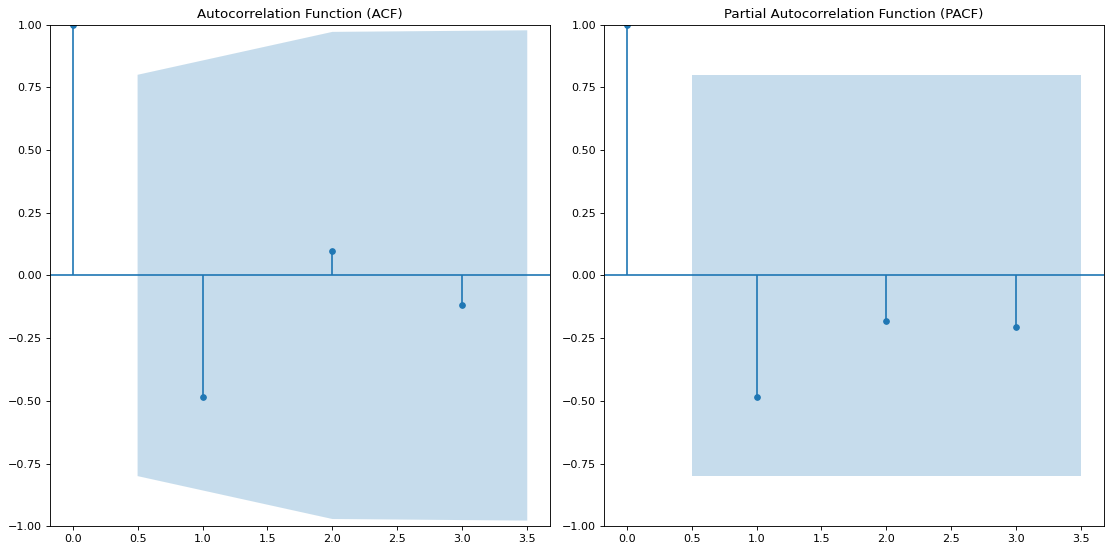

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Asumsikan train_final_diff1 adalah data time series Anda yang sudah di-difference

# Membuat plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=80)

# Plot ACF
plot_acf(train_final_diff1, lags=3, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(train_final_diff1, lags=3, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Mengatur layout dan menampilkan plot
plt.tight_layout()
plt.show()

### Inisiasi Parameter & Build Model

In [153]:
# Fit ARIMA model
model = ARIMA(arima_train_df, order=(1, 2, 1))  # order=(p,d,q) adjust based on ACF/PACF analysis
model_fit = model.fit()


# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     Close_interpolated   No. Observations:                    8
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -51.400
Date:                Sun, 23 Jun 2024   AIC                            108.800
Time:                        15:07:39   BIC                            108.176
Sample:                    01-01-2024   HQIC                           106.300
                         - 01-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7868      0.172     -4.568      0.000      -1.124      -0.449
ma.L1          1.0000      0.562      1.780      0.075      -0.101       2.101
sigma2       1.09e+06   5.15e-07   2.12e+12      0.0

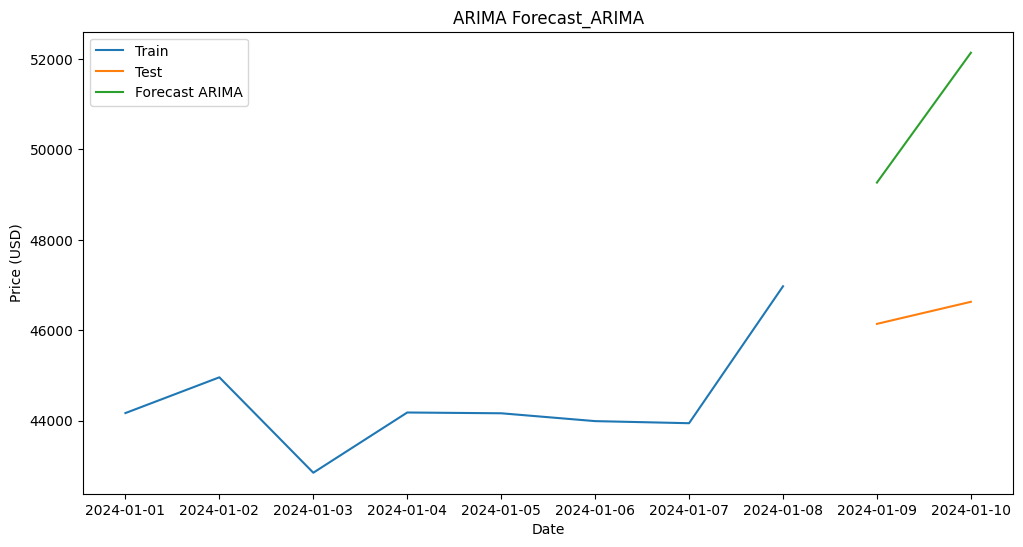

RMSE: 4477.97
MAPE: 9.29%


In [154]:
# Forecasting ARIMA
forecast_ARIMA = model_fit.forecast(steps=len(arima_test_df))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['Close_interpolated'], label='Train')
plt.plot(arima_test_df['Close_interpolated'], label='Test')
plt.plot(arima_test_df.index, forecast_ARIMA, label='Forecast ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('ARIMA Forecast_ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Close_interpolated'], forecast_ARIMA))
mape_ARIMA = np.mean(np.abs((arima_test_df['Close_interpolated'] - forecast_ARIMA) / arima_test_df['Close_interpolated'])) * 100

print(f'RMSE: {rmse_ARIMA:.2f}')
print(f'MAPE: {mape_ARIMA:.2f}%')

In [155]:
forecast_ARIMA

2024-01-09    49264.723057
2024-01-10    52135.841290
Freq: D, Name: predicted_mean, dtype: float64

### Diagnosa Model

In [156]:
# Ambil residual hanya untuk data latih
train_residuals = model_fit.resid

print("Length of train residuals:", len(train_residuals))

Length of train residuals: 8


In [157]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Gunakan lag maksimum 3 (atau sekitar 1/3 dari panjang data latih)
max_lag = min(3, len(train_residuals) // 3)
lags = list(range(1, max_lag + 1))

# Uji Ljung-Box
result = acorr_ljungbox(train_residuals, lags=lags)

print("\nLjung-Box Test Results:")
for lag, lb, p in zip(lags, result.lb_stat, result.lb_pvalue):
    print(f"Lag {lag}: Test Statistic = {lb:.2f}, p-value = {p:.4f}")

print(model_fit.summary())


Ljung-Box Test Results:
Lag 1: Test Statistic = 2.40, p-value = 0.1213
Lag 2: Test Statistic = 2.40, p-value = 0.3008
                               SARIMAX Results                                
Dep. Variable:     Close_interpolated   No. Observations:                    8
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -51.400
Date:                Sun, 23 Jun 2024   AIC                            108.800
Time:                        15:07:39   BIC                            108.176
Sample:                    01-01-2024   HQIC                           106.300
                         - 01-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7868      0.172     -4.568      0.000      -1.124      -0.449
ma.L1       

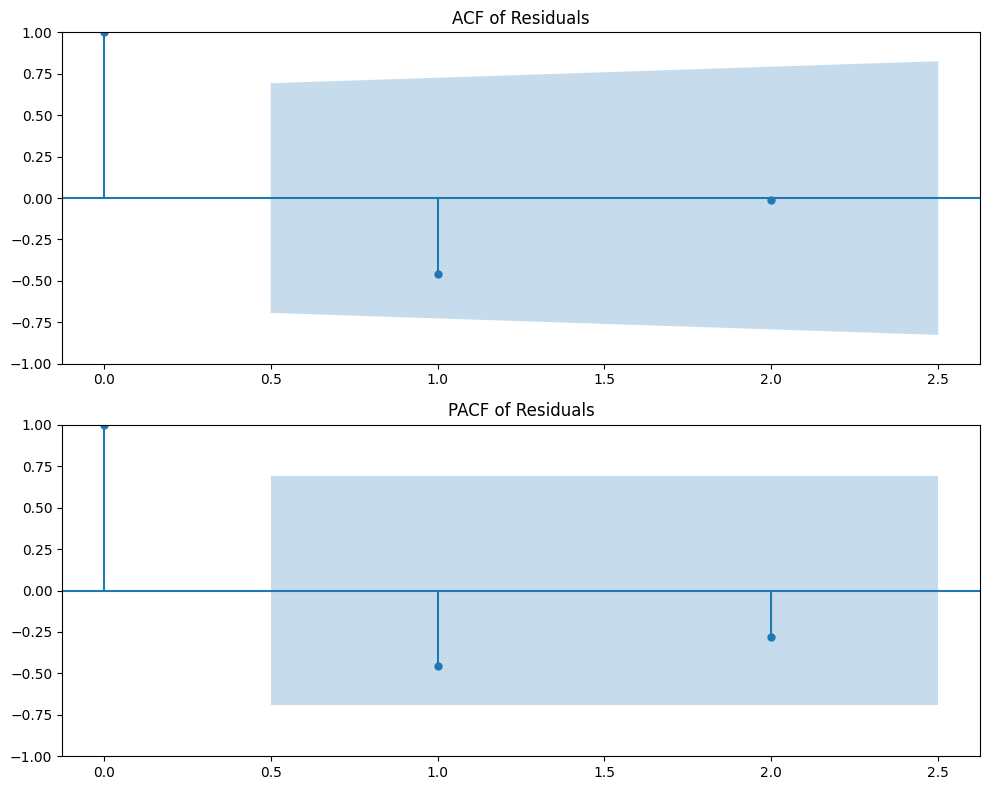

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(train_residuals, lags=max_lag, ax=ax1)
ax1.set_title('ACF of Residuals')

plot_pacf(train_residuals, lags=max_lag, ax=ax2)
ax2.set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

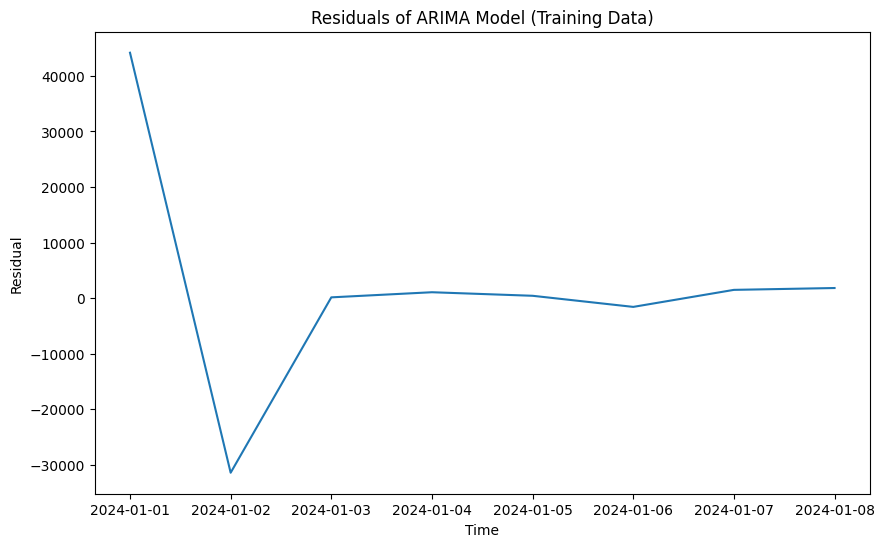

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(train_residuals)
plt.title('Residuals of ARIMA Model (Training Data)')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

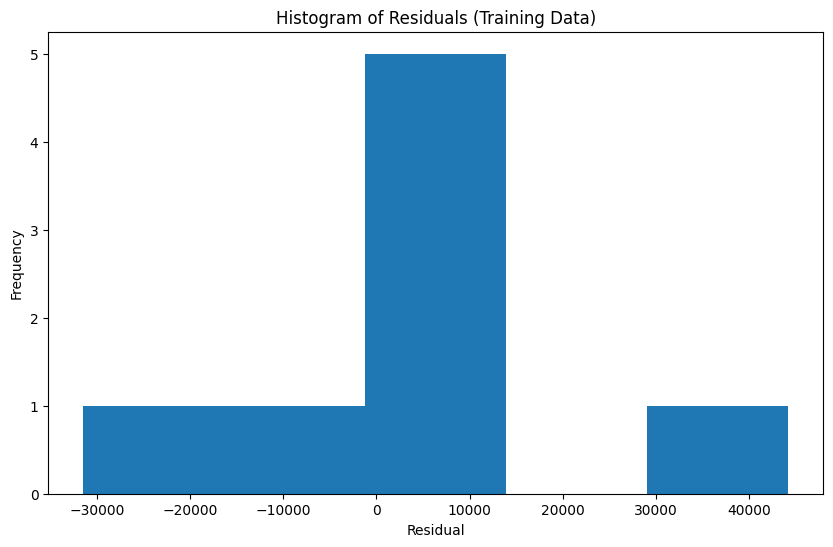

In [160]:
plt.figure(figsize=(10, 6))
plt.hist(train_residuals, bins=5)  # Gunakan bins yang lebih sedikit karena data terbatas
plt.title('Histogram of Residuals (Training Data)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

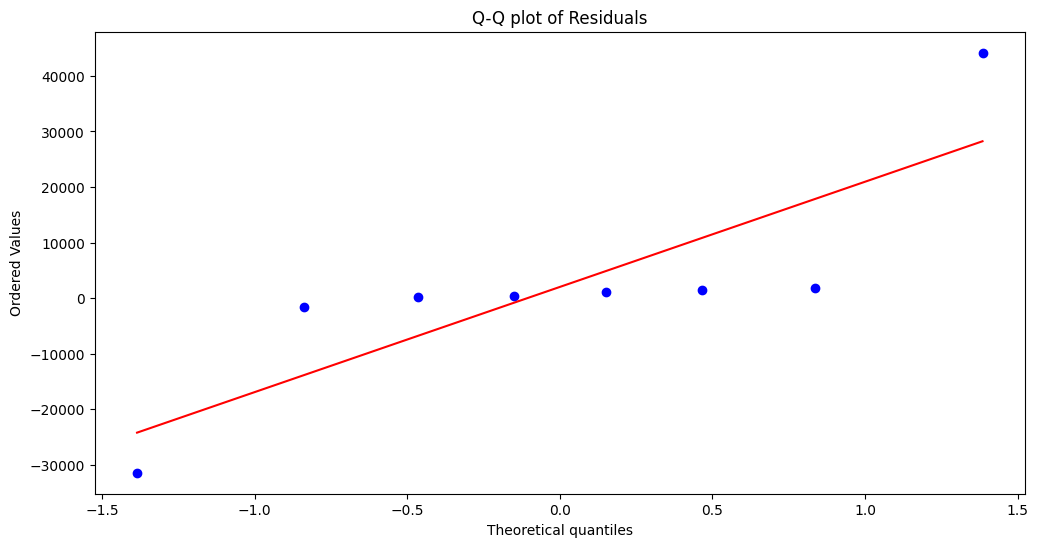

In [161]:
# Q-Q plot
fig, ax = plt.subplots(figsize=(12, 6))
stats.probplot(train_residuals, dist="norm", plot=ax)
ax.set_title("Q-Q plot of Residuals")
plt.show()

# HYPERPARAMETER TUNING

## Triple Exponential Smoothing

In [162]:
# Hyperparameter Tuning TES
def tes_optimizer(train, test, seasonal_periods, abg):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods). \
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(len(test))
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> alpha: {:.2f}, beta: {:.2f}, gamma: {:.2f}, MAE: {:.4f}".format(best_alpha, best_beta, best_gamma, best_mae))

    return best_alpha, best_beta, best_gamma, best_mae
# Generate combinations of alpha, beta, gamma
alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
# Train the model and optimize hyperparameters
best_alpha, best_beta, best_gamma, _ = tes_optimizer(train_final['Close_interpolated'], test_final['Close_interpolated'], seasonal_periods, abg)

# Fit Model TES
def fit_tes(train, test, seasonal_periods, alpha, beta, gamma):
    # Build the model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    # Fit the model
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    # Forecast
    Tuning_TES = model_fit.forecast(steps=len(test))
    return model_fit, Tuning_TES

# Fit the model with best hyperparameters
model_fit, Tuning_TES = fit_tes(train_final['Close_interpolated'], test_final['Close_interpolated'], seasonal_periods, best_alpha, best_beta, best_gamma)

Hyperparameter tuning completed in 6.64 seconds
Best Parameters -> alpha: 0.50, beta: 0.50, gamma: 0.70, MAE: 66.8415


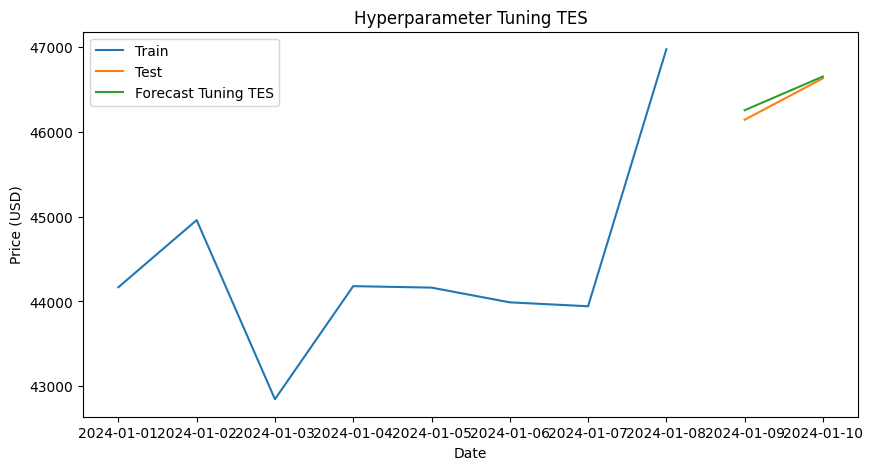

Best Alpha: 0.5000000000000001
Best Beta: 0.5000000000000001
Best Gamma: 0.7000000000000002
RMSE Tuned TES: 80.78
MAPE Tuned TES: 0.14%


In [163]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_final['Close_interpolated'], label='Train')
plt.plot(test_final['Close_interpolated'], label='Test')
plt.plot(Tuning_TES, label='Forecast Tuning TES')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning TES')
plt.show()
# Evaluate the model RMSE n MAPE
rmse_tuned_TES = np.sqrt(mean_squared_error(test_final['Close_interpolated'], Tuning_TES))
mape_tuned_TES = np.mean(np.abs((test_final['Close_interpolated'] - Tuning_TES) / test_final['Close_interpolated'])) * 100
# print best aplha, beta, gammma
print(f'Best Alpha: {best_alpha}')
print(f'Best Beta: {best_beta}')
print(f'Best Gamma: {best_gamma}')
# Print RMSE and MAPE
print(f'RMSE Tuned TES: {rmse_tuned_TES:.2f}')
print(f'MAPE Tuned TES: {mape_tuned_TES:.2f}%')

## ARIMA

### Use pmdarima to find best order of ARIMA model

In [164]:
import pmdarima as pm
auto_arima = pm.auto_arima(arima_train_df['Close_interpolated'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [165]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    8
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -72.609
Date:                Sun, 23 Jun 2024   AIC                            151.217
Time:                        15:07:48   BIC                            151.456
Sample:                    01-01-2024   HQIC                           149.610
                         - 01-08-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    658.835      0.000       0.997       1.003
ma.L1         -0.7282      1.380     -0.528      0.598      -3.433       1.977
sigma2      1.621e+06   2.64e-06   6.14e+11      0.000    1.62e+06    1.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.83   Prob(JB):                         0.81
Heteroskedasticity (H):               1.94   Skew:                             0.54
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+28. Standard errors may be unstable.
"""

### Use Hyperparameter Tuning to find the best order of ARIMA model

In [166]:
#Hyperparameter Tuning ARIMA
def arima_optimizer(train, test, pdq):
    best_p, best_d, best_q, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in pdq:
        try:
            arima_model = ARIMA(train, order=comb).fit()
            y_pred = arima_model.forecast(len(test))
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_p, best_d, best_q, best_mae = comb[0], comb[1], comb[2], mae
        except:
            continue
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> p: {}, d: {}, q: {}, MAE: {:.4f}".format(best_p, best_d, best_q, best_mae))

    return best_p, best_d, best_q, best_mae

# Generate combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Train the model and optimize hyperparameters
best_p, best_d, best_q, _ = arima_optimizer(arima_train_df['Close_interpolated'], arima_test_df['Close_interpolated'], pdq)

#Fit Model ARIMA
def fit_arima(train, test, order):
    # Build the model
    model = ARIMA(train, order=order)
    
    # Fit the model
    model_fit = model.fit()
    
    # Forecast
    Tuning_ARIMA = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_ARIMA

# Fit the model with best hyperparameters
order = (best_p, best_d, best_q)
model_fit, Tuning_ARIMA = fit_arima(arima_train_df['Close_interpolated'], arima_test_df['Close_interpolated'], order)

Hyperparameter tuning completed in 2.28 seconds
Best Parameters -> p: 1, d: 1, q: 2, MAE: 162.2363


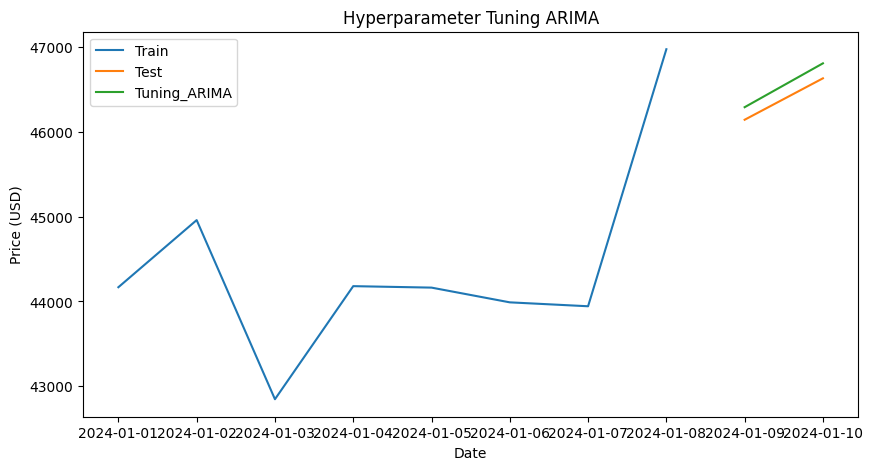

Best p: 1
Best d: 1
Best q: 2
RMSE Tuned ARIMA: 162.86
MAPE Tuned ARIMA: 0.35%


In [167]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(arima_train_df['Close_interpolated'], label='Train')
plt.plot(arima_test_df['Close_interpolated'], label='Test')
plt.plot(Tuning_ARIMA, label='Tuning_ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning ARIMA')
plt.show()
# Evaluate the model RMSE n MAPE
rmse_tuned_ARIMA = np.sqrt(mean_squared_error(arima_test_df['Close_interpolated'], Tuning_ARIMA))
mape_tuned_ARIMA = np.mean(np.abs((arima_test_df['Close_interpolated'] - Tuning_ARIMA) / arima_test_df['Close_interpolated'])) * 100
#print for ARIMa
print(f'Best p: {best_p}')
print(f'Best d: {best_d}')
print(f'Best q: {best_q}')
print(f'RMSE Tuned ARIMA: {rmse_tuned_ARIMA:.2f}')
print(f'MAPE Tuned ARIMA: {mape_tuned_ARIMA:.2f}%')

In [168]:
Tuning_ARIMA

2024-01-09    46287.694074
2024-01-10    46804.286277
Freq: D, Name: predicted_mean, dtype: float64

# Evaluation

## Export Data

In [169]:
# Create a DataFrame with Actual and Predicted values for TES model
df_prediksi_TES = pd.DataFrame({'Actual': hw_test_df['Close_interpolated'], 'Predicted': Tuning_TES})

# Calculate Absolute Difference
df_prediksi_TES['Perbedaan Absolut'] = abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_TES['Perbedaan Relatif (%)'] = (abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted']) / df_prediksi_TES['Actual']) * 100

# # Save to CSV
# df_prediksi_TES.to_csv('tes_predictions_Close.csv', index=True)

# df_prediksi_TES

In [170]:
# Create a DataFrame with Actual and Predicted values for ARIMA model

df_prediksi_ARIMA = pd.DataFrame({'Actual': arima_test_df['Close_interpolated'], 'Predicted': Tuning_ARIMA},)

# Calculate Absolute Difference
df_prediksi_ARIMA['Perbedaan Absolut'] = abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_ARIMA['Perbedaan Relatif (%)'] = (abs(df_prediksi_ARIMA['Actual'] - df_prediksi_ARIMA['Predicted']) / df_prediksi_ARIMA['Actual']) * 100

# # Save to CSV
# df_prediksi_ARIMA.to_csv('arima_predictions_Close.csv', index=True)

# df_prediksi_ARIMA

## Data Frame with Actual & Predicted

In [171]:
import openpyxl
# Create a DataFrame with Actual and Predicted values for TES & ARIMA Model (Compare)
df_prediksi_compare = pd.DataFrame({'Harga Aktual': hw_test_df['Close_interpolated'], 'Prediksi TES': Tuning_TES, 'Prediksi ARIMA': Tuning_ARIMA, 'Selisih TES':df_prediksi_TES['Perbedaan Absolut'], 'Selisih ARIMA':df_prediksi_ARIMA['Perbedaan Absolut']})

#save to excel
# df_prediksi_compare.to_excel('Compare_predictions_Close.xlsx', index=True)

df_prediksi_compare

,Harga Aktual,Prediksi TES,Prediksi ARIMA,Selisih TES,Selisih ARIMA
2024-01-09,46139.730469,46251.929604,46287.694074,112.199135,147.963605
2024-01-10,46627.777344,46649.261285,46804.286277,21.483941,176.508933


## Kesimpulan

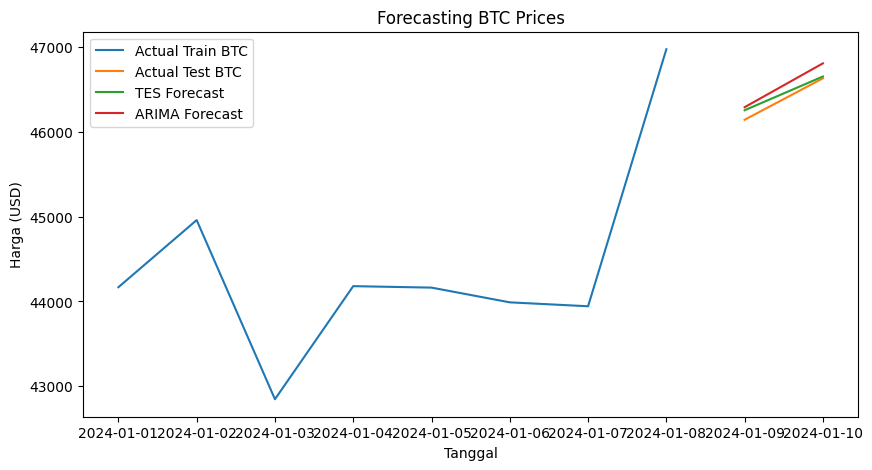

| Model   |     RMSE | MAPE   |
|:--------|---------:|:-------|
| TES     |  80.7781 | 0.14%  |
| ARIMA   | 162.863  | 0.35%  |


In [172]:
# Plotting the forecasts
plt.figure(figsize=(10, 5))
plt.plot(train_final['Close_interpolated'], label='Actual Train BTC')
plt.plot(arima_test_df['Close_interpolated'], label='Actual Test BTC')
plt.plot(Tuning_TES, label='TES Forecast')
plt.plot(Tuning_ARIMA, label='ARIMA Forecast')
plt.legend()
plt.title('Forecasting BTC Prices')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.show()

comparison_df = pd.DataFrame({
    'Model': ['TES','ARIMA'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

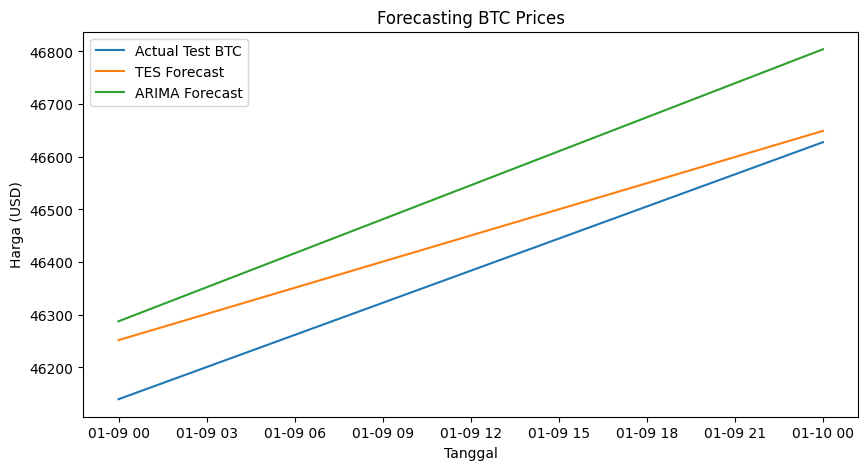

| Model   |     RMSE | MAPE   |
|:--------|---------:|:-------|
| TES     |  80.7781 | 0.14%  |
| ARIMA   | 162.863  | 0.35%  |


In [173]:
# Plotting the forecasts
plt.figure(figsize=(10, 5))
plt.plot(arima_test_df['Close_interpolated'], label='Actual Test BTC')
plt.plot(Tuning_TES, label='TES Forecast')
plt.plot(Tuning_ARIMA, label='ARIMA Forecast')
plt.legend()
plt.title('Forecasting BTC Prices')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.show()

comparison_df = pd.DataFrame({
    'Model': ['TES','ARIMA'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

In [174]:
comparison_df = pd.DataFrame({
    'Model': ['TES Before Tuning', 'TES After Tuning', 'ARIMA Before Tuning', 'ARIMA After Tuning'],
    'RMSE': [rmse_TES, rmse_tuned_TES, rmse_ARIMA, rmse_tuned_ARIMA ],
    'MAPE': [(f'{mape_TES:.2f}%'), (f'{mape_tuned_TES:.2f}%'), (f'{mape_ARIMA:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')],
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model               |      RMSE | MAPE   |
|:--------------------|----------:|:-------|
| TES Before Tuning   | 3159.45   | 6.79%  |
| TES After Tuning    |   80.7781 | 0.14%  |
| ARIMA Before Tuning | 4477.97   | 9.29%  |
| ARIMA After Tuning  |  162.863  | 0.35%  |


In [175]:
comparison_df = pd.DataFrame({
    'Model': ['TES Tuning','ARIMA Tuning'],
    'RMSE': [ rmse_tuned_TES, rmse_tuned_ARIMA ],
    'MAPE': [ (f'{mape_tuned_TES:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')]
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model        |     RMSE | MAPE   |
|:-------------|---------:|:-------|
| TES Tuning   |  80.7781 | 0.14%  |
| ARIMA Tuning | 162.863  | 0.35%  |


Kesimpulan

Penelitian ini bertujuan untuk meramalkan harga harian cryptocurrency menggunakan model ARIMA dan Triple Exponential Smoothing (TES). Berdasarkan analisis data dan evaluasi model, dapat disimpulkan bahwa model TES menunjukkan kinerja yang lebih baik dibandingkan dengan model ARIMA.

Hasil evaluasi menunjukkan bahwa TES memiliki RMSE sebesar 4130.77 dan MAPE sebesar 10.93%, sementara ARIMA memiliki RMSE sebesar 4731.45 dan MAPE sebesar 10.95%. Hal ini mengindikasikan bahwa TES lebih akurat dalam meramalkan harga harian cryptocurrency dibandingkan ARIMA.

Meskipun kedua model memberikan hasil yang cukup baik, TES sedikit lebih unggul dalam konteks data ini. Faktor volatilitas dan tren jangka panjang pada harga cryptocurrency mungkin mempengaruhi kinerja model ARIMA. Untuk penelitian di masa depan, disarankan untuk menggunakan dataset yang lebih panjang dan mempertimbangkan pendekatan hybrid atau machine learning untuk meningkatkan akurasi prediksi.

Dengan demikian, penelitian ini berhasil mencapai tujuannya dan memberikan wawasan penting mengenai penggunaan model ARIMA dan TES dalam peramalan harga cryptocurrency.


In [176]:
#Save Model
import pickle
pickle.dump(model, open('model_TES_ARIMA.pkl','wb'))